U-net is a versatile model used for many different applications. It was designed for biomedical image segmentation. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

It's an autoencoder, consisting of an encoder (downsampling) part and a decoder (upsampling) part with skip connections between the encoder and decoder layers. The skip connections allow the model to capture finer details at higher resolutions.


In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
input_fnames = glob.glob('/data/anitha/small_seg_set/input_channel/*.npy')

In [3]:
ip_fnames_list = []
for ip_fname in input_fnames:
    cur_fname = os.path.split(ip_fname)[-1]
    tar_fname = os.path.join('/data/anitha/small_seg_set/target_channel', cur_fname)
    if not os.path.exists(tar_fname):
        print(tar_fname, os.path.exists(tar_fname))
    ip_fnames_list.append(cur_fname)
ip_fnames_list = np.asarray(ip_fnames_list)
fnames_train, fnames_test = train_test_split(ip_fnames_list, test_size=0.15, random_state=42)
fnames_train, fnames_val = train_test_split(fnames_train, test_size=0.15, random_state=42)
print(len(fnames_train))

5006


-0.430574988017438 4.424933529011037


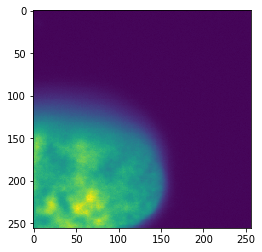

In [4]:
ip = np.load(os.path.join('/data/anitha/small_seg_set/input_channel',fnames_train[0]))
print(ip.min(), ip.max())
plt.imshow(ip)

n19_r640-896_c768-1024.npy
False True


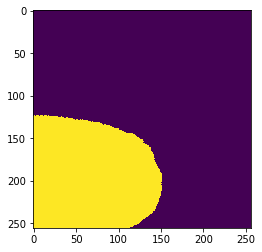

In [5]:
print(fnames_train[0])
tar = np.load(os.path.join('/data/anitha/small_seg_set/target_channel',fnames_train[0]))
print(tar.min(), tar.max())
plt.imshow(tar)

In [6]:
import keras

class DataSet(keras.utils.Sequence):
    def __init__(self,
                 fnames,
                 input_dir,
                 target_dir,
                 batch_size,
                 shuffle=True):
        """Init
        
        :param str input_dir:
        :param str target_dir:
        :param int batch_size:
        """
        
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.batch_size = batch_size
        self.fnames = np.asarray(fnames)
        self.num_samples = len(fnames)
        self.shuffle = shuffle
        
    def __len__(self):
        """Gets the number of batches per epoch"""

        n_batches = int(np.ceil(self.num_samples / self.batch_size))
        return n_batches

    def get_steps_per_epoch(self):
        """
        Returns steps per epoch which is number of training samples per
        epoch divided by batch size.

        :return int steps_per_epoch: Steps per epoch
        """
        return self.steps_per_epoch
        
    def on_epoch_end(self):
        """Update indices and shuffle after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.fnames)
            
    def __getitem__(self, index):
        """Get a batch of data"""
        
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        if end_idx >= self.num_samples:
            end_idx = self.num_samples

        input_image = []
        target_image = []
        aug_idx = 0
        for idx in range(start_idx, end_idx, 1):
            cur_ip = np.load(os.path.join(self.input_dir, self.fnames[idx]))
            cur_tar = np.load(os.path.join(self.target_dir, self.fnames[idx]))
            input_image.append(cur_ip[:, :, np.newaxis])
            target_image.append(cur_tar[:, :, np.newaxis])
        input_image = np.stack(input_image)
        target_image = np.stack(target_image)
        return input_image, target_image
            

Using TensorFlow backend.


In [7]:
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D, Dropout, 
                          Input, MaxPooling2D, UpSampling2D)

def conv_block(input_tensor, n_filters, kernel_size=3, dropout=0.2, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if dropout:
        x = Dropout(dropout)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal", 
               padding="same")(x)
    if dropout:
        x = Dropout(dropout)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# The original Unet used valid convolutions but for convenience we will use convolutions with 'same' padding
def Unet(input_img, n_filters, dropout=0.2, batchnorm=True):
    # contracting path
    c1 = conv_block(input_img, n_filters=n_filters[0], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    m1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(m1, n_filters=n_filters[1], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    m2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(m2, n_filters=n_filters[2], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    m3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv_block(m3, n_filters=n_filters[3], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    m4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv_block(m4, n_filters=n_filters[4], kernel_size=3, dropout=dropout, batchnorm=batchnorm)

    # expansive path
    u4 = UpSampling2D(size=2)(c5)
    u4 = Concatenate()([u4, c4])
    c6 = conv_block(u4, n_filters=n_filters[3], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    
    u3 = UpSampling2D(size=2)(c6)
    u3 = Concatenate()([u3, c3])
    c7 = conv_block(u3, n_filters=n_filters[2], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    
    u2 = UpSampling2D(size=2)(c7)
    u2 = Concatenate()([u2, c2])
    c8 = conv_block(u2, n_filters=n_filters[1], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    
    u1 = UpSampling2D(size=2)(c8)
    u1 = Concatenate()([u1, c1])
    c9 = conv_block(u1, n_filters=n_filters[0], kernel_size=3, dropout=dropout, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    return input_img, outputs

In [8]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf

gpu_options = tf.GPUOptions(visible_device_list=str(1))
config = tf.ConfigProto(gpu_options=gpu_options,
                        allow_soft_placement=True,
                        log_device_placement=False)
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [9]:
input_img = Input((256, 256, 1), name='input_layer')
inputs, outputs = Unet(input_img=input_img, n_filters=[16, 32, 48, 64, 96])
with tf.device('/gpu:1'):
    model = Model(inputs=inputs, outputs=outputs)
opt = Adam(lr=0.0002)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_layer[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          dropout_1[0][0]                  
__________________________________________________________________________________________________
activation

In [10]:
callbacks=[ModelCheckpoint(filepath='../data/seg_model.hdf5',
                           mode=min,
                           monitor='val_loss',
                           save_best_only=True,
                           verbose=True),
           TensorBoard(log_dir='../data', 
                       histogram_freq=0, 
                       write_graph=True, 
                       write_images=False)]

ip_dir = '/data/anitha/small_seg_set/input_channel/'
tar_dir = '/data/anitha/small_seg_set/target_channel/'
train_dataset = DataSet(
                 fnames_train,
                 ip_dir,
                 tar_dir,
                 batch_size=8,
                 shuffle=True)

val_dataset = DataSet(
                 fnames_val,
                 ip_dir,
                 tar_dir,
                 batch_size=8,
                 shuffle=True)

with sess.as_default():
    history = model.fit_generator(train_dataset,
                                  validation_data=val_dataset,
                                  epochs=15, shuffle=True,
                                  callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:408: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/15
626/626 [==============================] - 61s 98ms/step - loss: 0.1369 - acc: 0.9819 - val_loss: 0.0537 - val_acc: 0.9935

Epoch 00001: val_loss improved from inf to 0.05367, saving model to ../data/seg_model.hdf5
Epoch 2/15
626/626 [==============================] - 52s 83ms/step - loss: 0.0468 - acc: 0.9938 - val_loss: 0.0396 - val_acc: 0.9887

Epoch 00002: val_loss improved from 0.05367 to 0.03958, saving model to ../data/seg_model.hdf5
Epoch 3/15
626/626 [==============================] - 52s 83ms/step - loss: 0.0281 - acc: 0.9945 - val_loss: 0.0426 - val_acc: 0.9835

Epoch 00003: val_loss did not improve
Epoch 4/15
626/626 [==============================] - 53s 84ms/step - loss: 0.0196 - acc: 0.9953 - val_loss: 0.0407 - val_acc: 0.9847

Epoch 00004: val_loss did not improve
Epoch 5/15
626/626 [==============================] - 53s 85ms/step - loss: 0.0152 - acc: 0.9957 - val_loss: 0.0435 - val_acc: 0.9831

Epoch 00005: val_loss did not improve
Epoch 6/15
626/626 [=====